In [2]:
%pip install sklearn
%pip install scikit-learn
%pip install matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import json

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

# IN DOMAIN EXPERIMENTS

## ENGLISH
We get the predictions made by the model for the english language and then we use the predictions together with the gold standar to get the accuracy.

In [5]:
lang = "English"
ruta_archivo = f"output/{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))


**Accuracy score of the English model**

In [6]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.9635336414997432

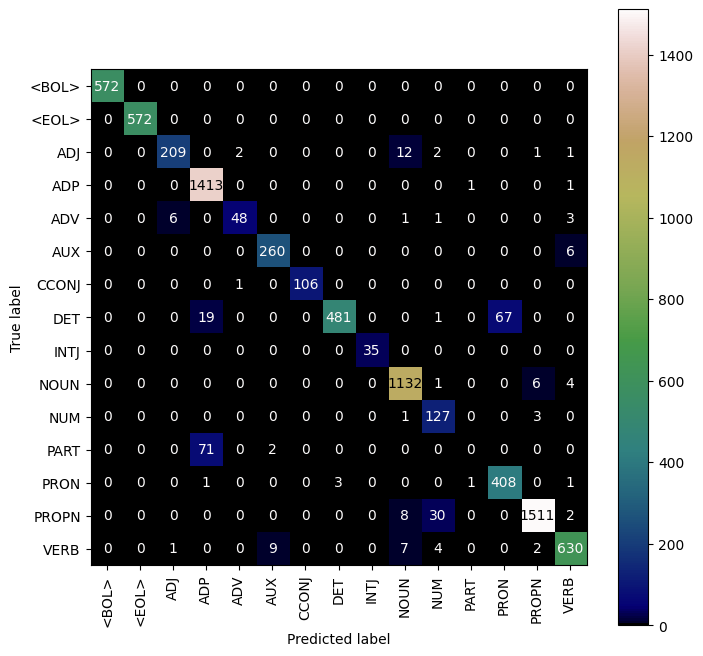

In [7]:
#create the confusion matrix
tags_set = sorted(set(all_predictions))
cm=confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

The confusion matrix shows that there is high correlation between the actual tags and the model's predictions. Overall, the number of errors is low in all tags and the accuracy score is high (0.96). However, the model does not predict correctly the PART (Particle) tag, and it confuses it with the ADP (Adposition) tag. Both tags have in common that the usually appear as elements that don't have lexical meaning but are crucial for the sentence meaning, and common words in English like 'to' could be PART or ADP depending on the context. Also, PART is the less common tag in the training corpus. All of this explains why the model fails with this tag.

## SPANISH

In [8]:
lang = "Spanish"
ruta_archivo = f"output/{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))


In [9]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.8800530377724135

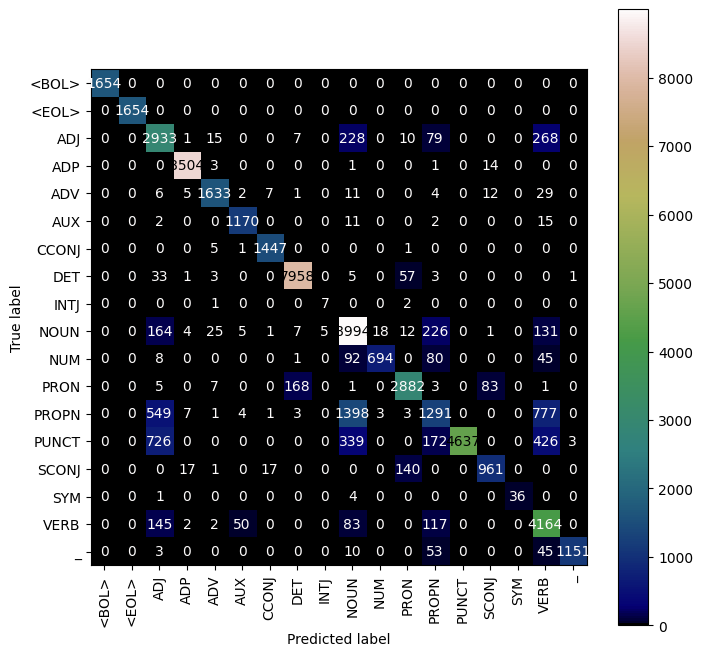

In [10]:
accuracy
#create the confusion matrix
tags_set = sorted(set(all_predictions))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

As in English, the confusion matrix for Spanish shows that there is also high correlation between the predictions and the actual clases in Spanish. However, in Spanish, the model makes more errors and it is reflected both in the matrix and in the slightly lower accuracy score (0.88). In this case, it is worth mentioning that the tags that the model confuses the most are the NOUN and PROPN. As the NOUN and PROPN are similar between them, this error is understandable. Also, the model makes a remarkable number of errors with tags like VERB or PUNCT.

# OUT-OF-DOMAIN RESULTS

In [3]:
lang = "English"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))

In [4]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.42317323013885727

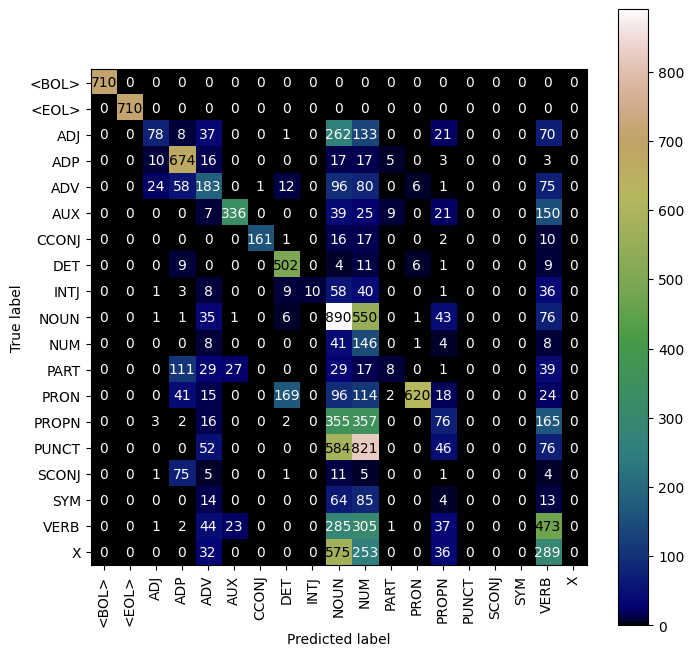

In [7]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()